# Chapter 4: Polynomial Regression

**From Statistical Rethinking by Richard McElreath**

This notebook covers **polynomial regression** - fitting curved relationships using polynomial functions.

## What We'll Learn

1. **When linear models aren't enough** - detecting non-linear relationships
2. **Polynomial models** - adding x², x³, etc. as predictors
3. **Standardization** - why it's critical for polynomials
4. **Model comparison** - comparing different polynomial degrees
5. **Overfitting warning** - dangers of high-degree polynomials

## The Challenge

Linear regression assumes: μᵢ = α + β·xᵢ

But what if the relationship is **curved**?

**Solution:** Polynomial regression
- Degree 1 (linear): μᵢ = α + β₁·x
- Degree 2 (quadratic): μᵢ = α + β₁·x + β₂·x²
- Degree 3 (cubic): μᵢ = α + β₁·x + β₂·x² + β₃·x³
- And so on...

## Key Insight

Polynomial regression is still **linear in the parameters** (α, β₁, β₂, ...), just non-linear in x.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sys
from pathlib import Path

# Import our quap implementation
sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

# Set random seed
np.random.seed(42)
rng = np.random.default_rng(42)

plt.style.use('default')
%matplotlib inline

print('✓ Imports loaded')

✓ Imports loaded


---

## Step 1: Load the Data

We'll use the **Howell1** dataset again, focusing on the relationship between **height** and **weight**.

In [10]:
# Load Howell dataset
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
howell = pd.read_csv(url, sep=";")  # Note: sep=";" because it's semicolon-separated

# Filter for adults only
adult_data = howell[howell['age'] >= 18].copy()

# Extract variables
height = adult_data['height'].values
weight = adult_data['weight'].values

print(f"Dataset: {len(adult_data)} adults")
print(f"Height range: [{height.min():.1f}, {height.max():.1f}] cm")
print(f"Weight range: [{weight.min():.1f}, {weight.max():.1f}] kg")

Dataset: 352 adults
Height range: [136.5, 179.1] cm
Weight range: [31.1, 63.0] kg


## Step 2: Visualize the Relationship

Let's see if a linear model is sufficient.

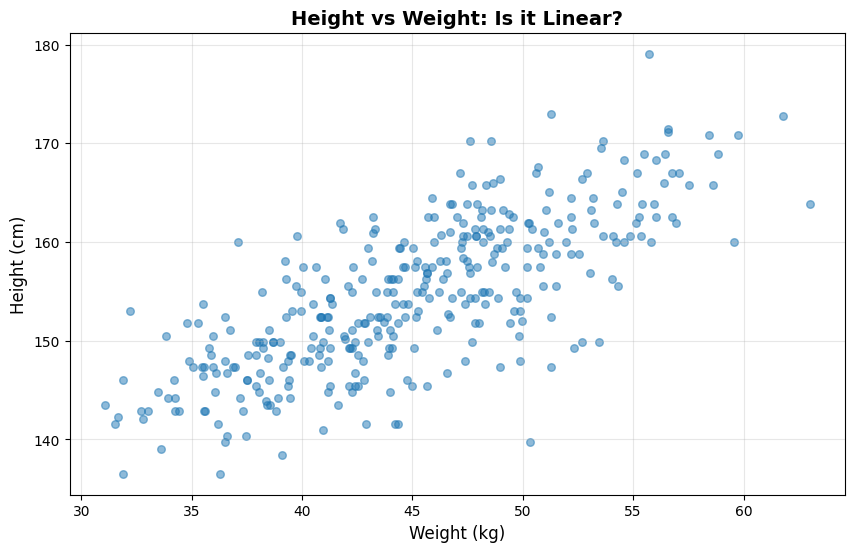

Question: Does this look perfectly linear, or is there some curvature?
Observation: The relationship might have slight curvature at the extremes


In [11]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(weight, height, alpha=0.5, s=30)
plt.xlabel('Weight (kg)', fontsize=12)
plt.ylabel('Height (cm)', fontsize=12)
plt.title('Height vs Weight: Is it Linear?', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print("Question: Does this look perfectly linear, or is there some curvature?")
print("Observation: The relationship might have slight curvature at the extremes")

---

## Step 3: Standardization - **Critical for Polynomials!**

### Why Standardize?

When using polynomials (x, x², x³, ...), the raw values can become **extremely large**:
- If weight = 50 kg, then weight² = 2500, weight³ = 125,000!
- This causes **numerical instability** in optimization
- Different scales make it hard to interpret coefficients

### Standardization Formula

$$x_{std} = \frac{x - \bar{x}}{\text{sd}(x)}$$

**Result:** 
- Mean = 0
- Standard deviation = 1
- Values typically in range [-3, 3]

### Benefits

1. **Numerical stability** - all predictors on similar scale
2. **Easier interpretation** - coefficients comparable
3. **Better priors** - same prior works for all polynomial terms
4. **Faster convergence** - optimization is easier

Original weight:
  Mean: 44.99 kg
  SD: 6.45 kg
  Range: [31.1, 63.0]

Standardized weight:
  Mean: 0.000000 (should be ≈ 0)
  SD: 1.000000 (should be ≈ 1)
  Range: [-2.16, 2.79]


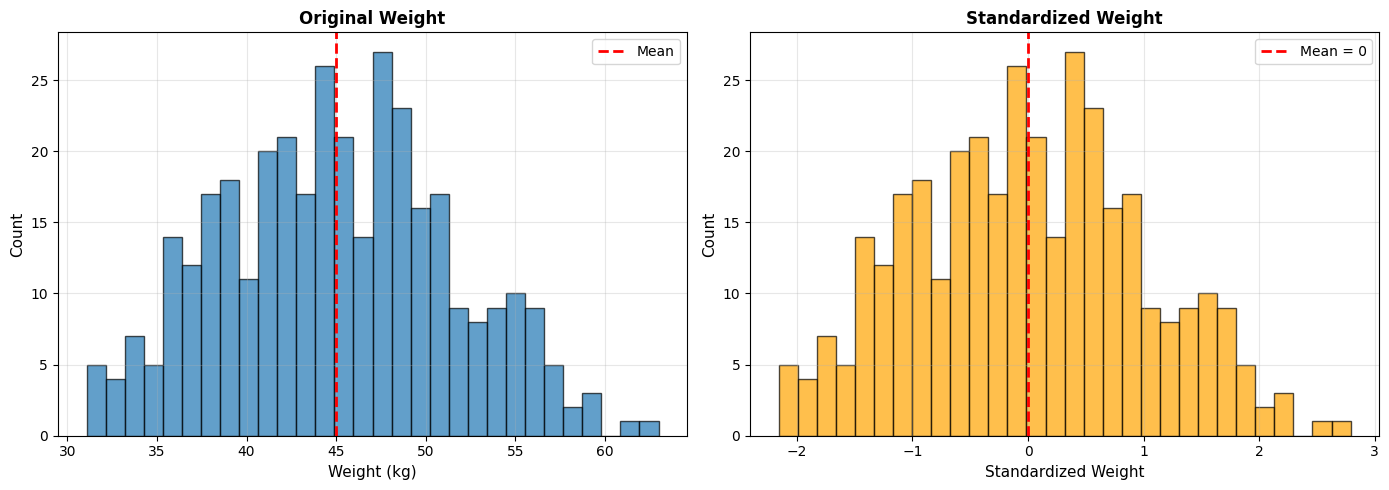

In [12]:
# Standardize weight
weight_mean = weight.mean()
weight_sd = weight.std()

weight_std = (weight - weight_mean) / weight_sd

print("Original weight:")
print(f"  Mean: {weight_mean:.2f} kg")
print(f"  SD: {weight_sd:.2f} kg")
print(f"  Range: [{weight.min():.1f}, {weight.max():.1f}]")

print("\nStandardized weight:")
print(f"  Mean: {weight_std.mean():.6f} (should be ≈ 0)")
print(f"  SD: {weight_std.std():.6f} (should be ≈ 1)")
print(f"  Range: [{weight_std.min():.2f}, {weight_std.max():.2f}]")

# Visualize standardization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(weight, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(weight_mean, color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_xlabel('Weight (kg)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Original Weight', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(weight_std, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
axes[1].set_xlabel('Standardized Weight', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Standardized Weight', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Step 4: Build Polynomial Models

We'll fit models of increasing degree and compare them.

### Models to Fit

1. **Degree 1 (Linear):** μᵢ = α + β₁·x_std
2. **Degree 2 (Quadratic):** μᵢ = α + β₁·x_std + β₂·x_std²
3. **Degree 3 (Cubic):** μᵢ = α + β₁·x_std + β₂·x_std² + β₃·x_std³
4. **Degree 4:** μᵢ = α + β₁·x_std + β₂·x_std² + β₃·x_std³ + β₄·x_std⁴
5. **Degree 5:** ... and so on
6. **Degree 6:** Getting into overfitting territory!

### Prior Specification

For all polynomial terms (β₁, β₂, β₃, ...):
- Use **Normal(0, 10)** (weakly informative)
- Because standardization puts everything on same scale
- Can use same prior for all coefficients!

In [13]:
def fit_polynomial_model(weight_std, height, degree, initial_alpha=None, initial_sigma=None):
    """
    Fit polynomial model of given degree using quap.
    
    Parameters:
    -----------
    weight_std : array
        Standardized weight values
    height : array
        Height values
    degree : int
        Degree of polynomial (1=linear, 2=quadratic, etc.)
    
    Returns:
    --------
    QuapResult object with fitted parameters
    """
    n = len(height)
    
    # Create polynomial features: [x, x², x³, ...]
    X = np.column_stack([weight_std**i for i in range(1, degree + 1)])
    
    # Initial parameter guesses
    if initial_alpha is None:
        initial_alpha = height.mean()
    if initial_sigma is None:
        initial_sigma = height.std()
    
    initial_betas = np.zeros(degree)  # Start betas at 0
    initial_params = np.concatenate([[initial_alpha], initial_betas, [np.log(initial_sigma)]])
    
    def neg_log_posterior(params):
        alpha = params[0]
        betas = params[1:degree+1]
        log_sigma = params[degree+1]
        sigma = np.exp(log_sigma)
        
        # Linear predictor: α + β₁x + β₂x² + β₃x³ + ...
        mu = alpha + X @ betas
        
        # Likelihood: height ~ Normal(mu, sigma)
        log_lik = np.sum(stats.norm.logpdf(height, loc=mu, scale=sigma))
        
        # Priors
        log_prior_alpha = stats.norm.logpdf(alpha, loc=178, scale=20)
        log_prior_betas = np.sum(stats.norm.logpdf(betas, loc=0, scale=10))
        log_prior_log_sigma = stats.norm.logpdf(log_sigma, loc=np.log(10), scale=1)
        
        # Jacobian for log(sigma)
        jacobian = log_sigma
        
        log_posterior = log_lik + log_prior_alpha + log_prior_betas + log_prior_log_sigma + jacobian
        
        return -log_posterior
    
    # Parameter names
    param_names = ['alpha'] + [f'beta{i}' for i in range(1, degree+1)] + ['log_sigma']
    
    # Fit with quap
    fit = quap(neg_log_posterior, initial_params=initial_params, param_names=param_names)
    
    return fit

print("✓ Polynomial model fitting function defined")

✓ Polynomial model fitting function defined


### Fit Models of Degree 1 through 6

In [14]:
# Fit models
print("Fitting polynomial models...")
print("="*60)

models = {}
for degree in range(1, 7):
    print(f"\nDegree {degree}...", end=" ")
    fit = fit_polynomial_model(weight_std, height, degree)
    models[degree] = fit
    print("✓")
    
    # Show MAP estimates
    coef_estimates = fit.coef()
    print(f"  α = {coef_estimates['alpha']:.2f}")
    for i in range(1, degree+1):
        print(f"  β{i} = {coef_estimates[f'beta{i}']:.2f}")
    print(f"  σ = {np.exp(coef_estimates['log_sigma']):.2f}")

print("\n" + "="*60)
print("All models fitted successfully!")

Fitting polynomial models...

Degree 1... ⚠️  Warning: Optimization may not have converged!
   Message: Desired error not necessarily achieved due to precision loss.
✓
  α = 154.60
  β1 = 5.83
  σ = 5.08

Degree 2... ⚠️  Warning: Optimization may not have converged!
   Message: Desired error not necessarily achieved due to precision loss.
✓
  α = 154.62
  β1 = 5.83
  β2 = -0.01
  σ = 5.08

Degree 3... ✓
  α = 154.58
  β1 = 6.17
  β2 = 0.04
  β3 = -0.14
  σ = 5.08

Degree 4... ⚠️  Warning: Optimization may not have converged!
   Message: Desired error not necessarily achieved due to precision loss.
✓
  α = 154.62
  β1 = 6.22
  β2 = -0.07
  β3 = -0.16
  β4 = 0.03
  σ = 5.08

Degree 5... ⚠️  Warning: Optimization may not have converged!
   Message: Desired error not necessarily achieved due to precision loss.
✓
  α = 154.70
  β1 = 5.88
  β2 = -0.32
  β3 = 0.17
  β4 = 0.11
  β5 = -0.06
  σ = 5.08

Degree 6... ⚠️  Warning: Optimization may not have converged!
   Message: Desired error not n

---

## Step 5: Visualize All Polynomial Fits

Let's plot all models on the same graph to compare.

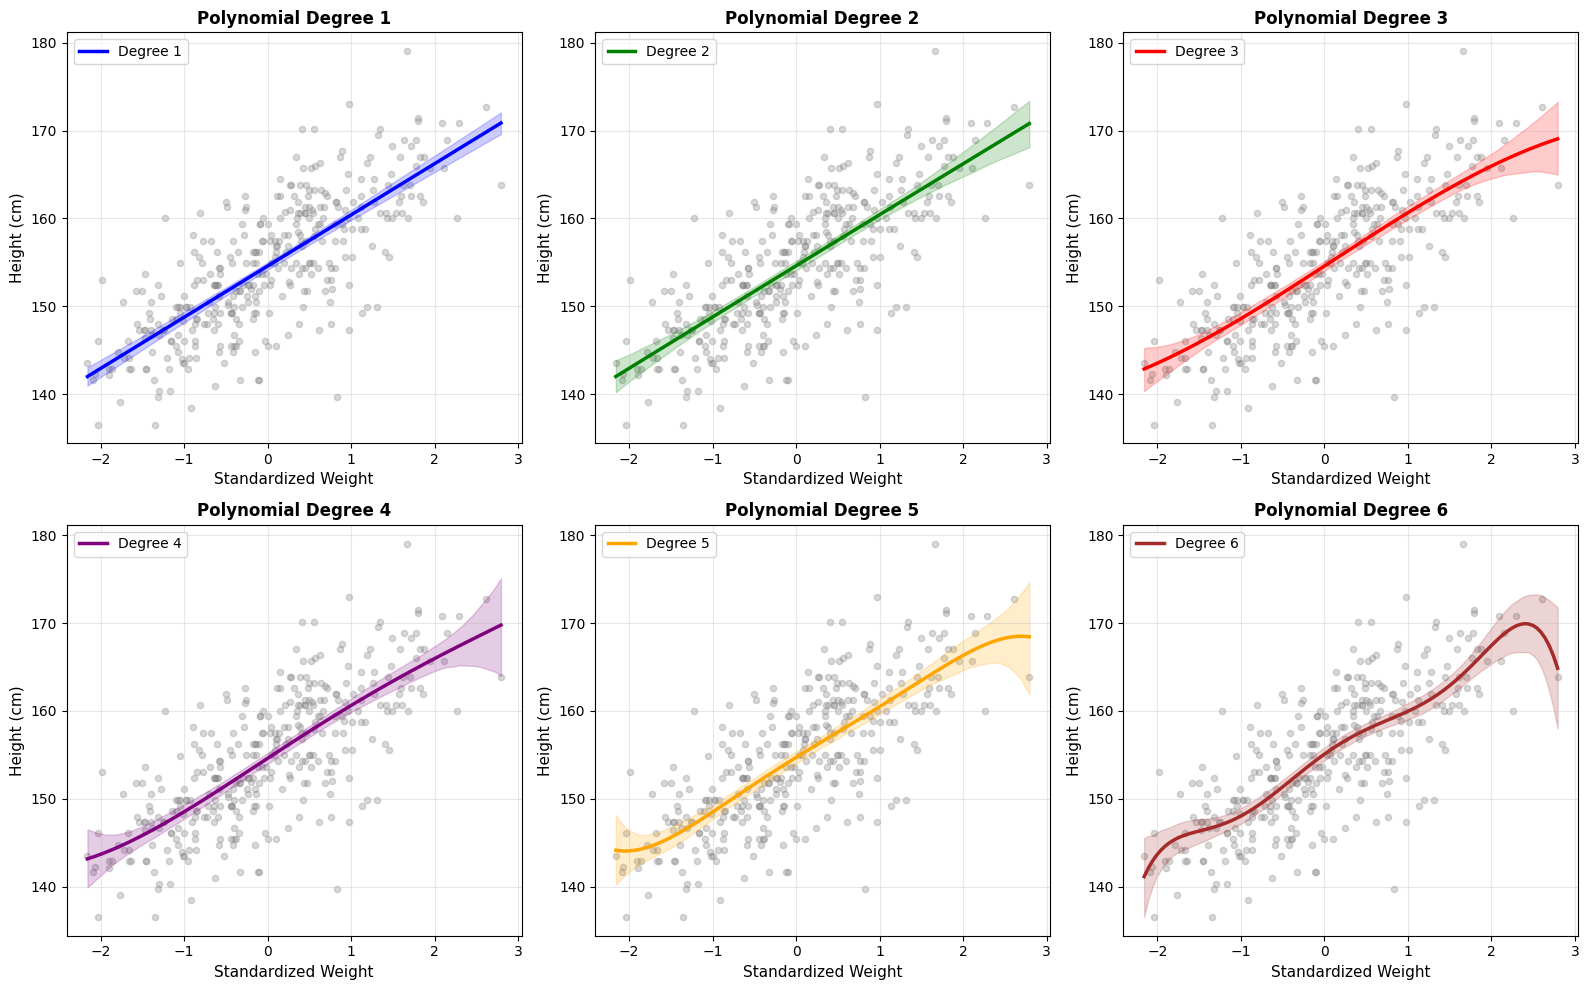

Observations:
• Degree 1: Straight line (linear)
• Degree 2: Slight curve (quadratic)
• Degree 3-4: More flexible curves
• Degree 5-6: Starting to wiggle more (potential overfitting!)


In [15]:
# Generate predictions for plotting
weight_std_seq = np.linspace(weight_std.min(), weight_std.max(), 100)

# Helper function to predict from fitted model
def predict_polynomial(fit, weight_std_new, degree):
    """Generate predictions from fitted polynomial model."""
    samples = fit.sample(n=1000, seed=42)
    alpha_samples = samples['alpha'].values
    beta_samples = np.column_stack([samples[f'beta{i}'].values for i in range(1, degree+1)])
    
    # Create polynomial features for new data
    X_new = np.column_stack([weight_std_new**i for i in range(1, degree + 1)])
    
    # Predictions: α + β₁x + β₂x² + ...
    mu_samples = alpha_samples[:, None] + beta_samples @ X_new.T
    
    # Summary statistics
    mu_mean = mu_samples.mean(axis=0)
    mu_lower = np.percentile(mu_samples, 5.5, axis=0)
    mu_upper = np.percentile(mu_samples, 94.5, axis=0)
    
    return mu_mean, mu_lower, mu_upper

# Plot all models
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

for idx, degree in enumerate(range(1, 7)):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(weight_std, height, alpha=0.3, s=20, color='gray')
    
    # Get predictions
    mu_mean, mu_lower, mu_upper = predict_polynomial(models[degree], weight_std_seq, degree)
    
    # Plot mean line
    ax.plot(weight_std_seq, mu_mean, color=colors[idx], linewidth=2.5, 
            label=f'Degree {degree}')
    
    # Plot uncertainty interval
    ax.fill_between(weight_std_seq, mu_lower, mu_upper, 
                    color=colors[idx], alpha=0.2)
    
    # Labels
    ax.set_xlabel('Standardized Weight', fontsize=11)
    ax.set_ylabel('Height (cm)', fontsize=11)
    ax.set_title(f'Polynomial Degree {degree}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print("• Degree 1: Straight line (linear)")
print("• Degree 2: Slight curve (quadratic)")
print("• Degree 3-4: More flexible curves")
print("• Degree 5-6: Starting to wiggle more (potential overfitting!)")

### Side-by-Side Comparison

Let's plot all models on one graph to see the differences clearly.

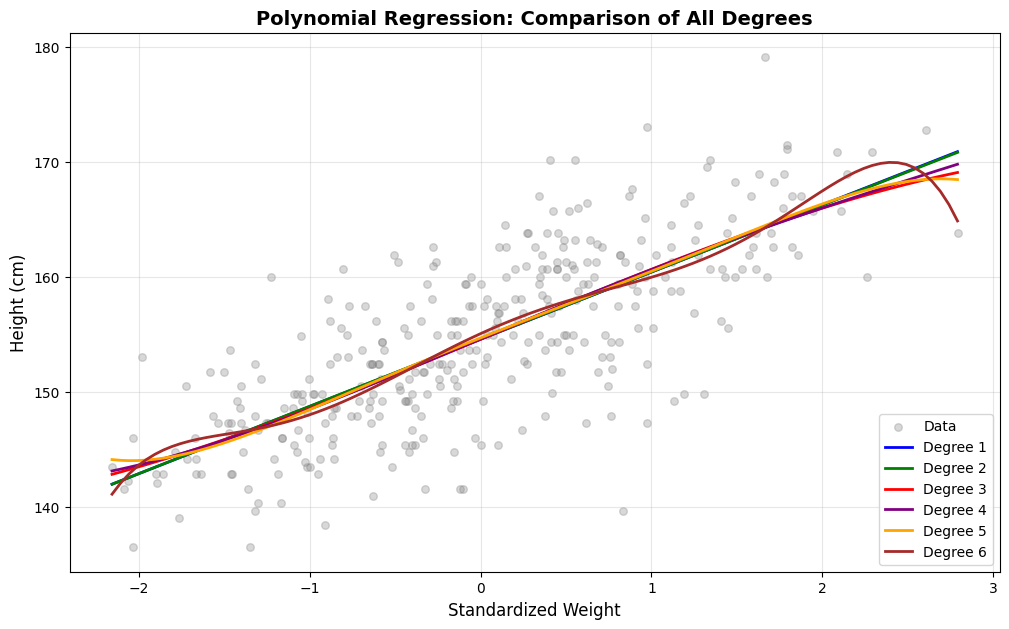

Key Observations:
• Low degrees (1-2): Simpler, smoother fits
• Medium degrees (3-4): Capture curvature without too much wiggle
• High degrees (5-6): More wiggly, fitting noise?


In [16]:
# All models on one plot
plt.figure(figsize=(12, 7))

# Scatter plot
plt.scatter(weight_std, height, alpha=0.3, s=30, color='gray', label='Data')

# Plot each polynomial
for degree in range(1, 7):
    mu_mean, _, _ = predict_polynomial(models[degree], weight_std_seq, degree)
    plt.plot(weight_std_seq, mu_mean, linewidth=2, label=f'Degree {degree}', 
             color=colors[degree-1])

plt.xlabel('Standardized Weight', fontsize=12)
plt.ylabel('Height (cm)', fontsize=12)
plt.title('Polynomial Regression: Comparison of All Degrees', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

print("Key Observations:")
print("• Low degrees (1-2): Simpler, smoother fits")
print("• Medium degrees (3-4): Capture curvature without too much wiggle")
print("• High degrees (5-6): More wiggly, fitting noise?")

---

## Step 6: The Overfitting Problem

### What is Overfitting?

**Overfitting** occurs when a model fits the **training data too well**, capturing:
- True underlying patterns ✓
- **Random noise** ✗

### Signs of Overfitting in Polynomials

1. **Excessive wiggling** - curves that don't make physical sense
2. **Poor out-of-sample prediction** - works on training data, fails on new data
3. **Extreme predictions** - absurd values outside data range
4. **Unstable coefficients** - large, sensitive parameter estimates

### The Bias-Variance Tradeoff

- **Low degree (e.g., 1-2):** 
  - High bias (might miss true patterns)
  - Low variance (stable predictions)
  
- **High degree (e.g., 5-6):**
  - Low bias (fits training data well)
  - High variance (unstable, overfits noise)

### What Degree Should We Use?

**Rule of thumb:**
- Start with **degree 2-3** for most applications
- Only go higher if there's strong theoretical reason
- Use **cross-validation** or **information criteria** (later chapters) to choose

### Better Alternative: Splines

Instead of polynomials, use **splines** (covered later in the book):
- More flexible
- Less prone to overfitting
- Better behavior at edges
- More interpretable

### Demonstration: Extrapolation Danger

Let's see what happens when we extrapolate beyond our data range.

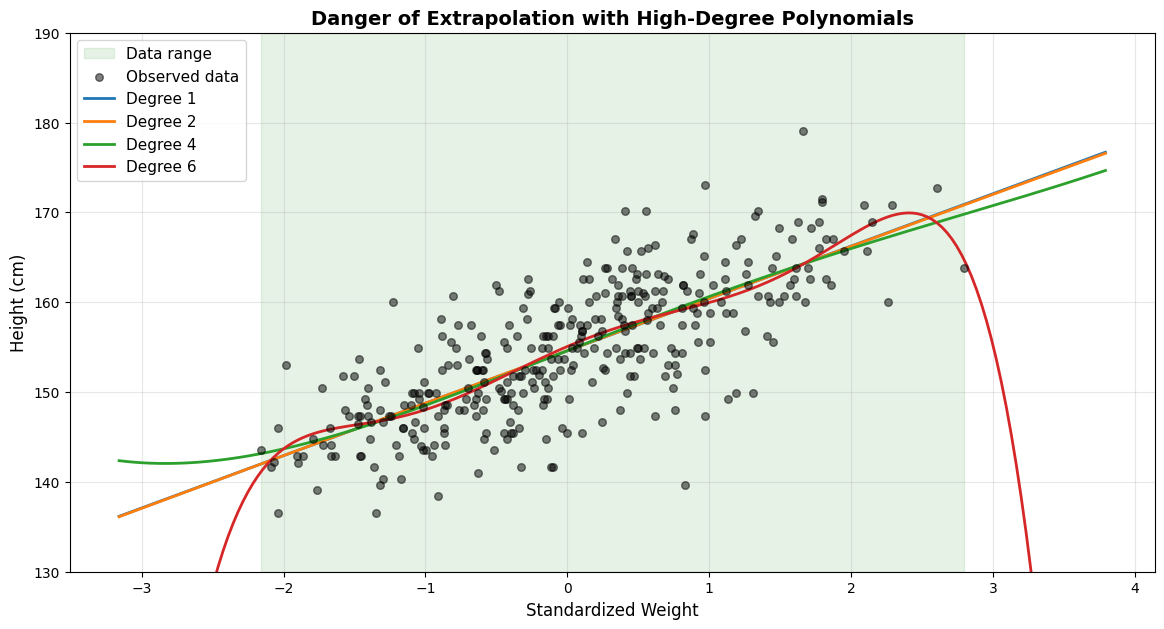

⚠️ WARNING: High-degree polynomials behave badly outside data range!
• Degree 1-2: Reasonable extrapolation
• Degree 4: Starting to curve unrealistically
• Degree 6: Absurd predictions!


In [17]:
# Extrapolate beyond data range
weight_std_extrap = np.linspace(weight_std.min() - 1, weight_std.max() + 1, 200)

plt.figure(figsize=(14, 7))

# Plot data range
plt.axvspan(weight_std.min(), weight_std.max(), alpha=0.1, color='green', 
            label='Data range')

# Scatter plot
plt.scatter(weight_std, height, alpha=0.5, s=30, color='black', 
            label='Observed data', zorder=5)

# Plot polynomials with extrapolation
for degree in [1, 2, 4, 6]:
    mu_mean, _, _ = predict_polynomial(models[degree], weight_std_extrap, degree)
    plt.plot(weight_std_extrap, mu_mean, linewidth=2, 
             label=f'Degree {degree}')

plt.xlabel('Standardized Weight', fontsize=12)
plt.ylabel('Height (cm)', fontsize=12)
plt.title('Danger of Extrapolation with High-Degree Polynomials', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(130, 190)
plt.show()

print("⚠️ WARNING: High-degree polynomials behave badly outside data range!")
print("• Degree 1-2: Reasonable extrapolation")
print("• Degree 4: Starting to curve unrealistically")
print("• Degree 6: Absurd predictions!")

---

## Summary

### What We Learned

1. **Polynomial regression** extends linear models to curved relationships
   - Degree 1: Linear
   - Degree 2: Quadratic (one curve)
   - Degree 3+: More complex curves

2. **Standardization is critical**
   - Prevents numerical instability
   - Makes coefficients comparable
   - Essential for polynomials!

3. **Model complexity tradeoff**
   - Too simple: Misses patterns (underfitting)
   - Too complex: Fits noise (overfitting)
   - Sweet spot: Usually degree 2-3

4. **Dangers of high-degree polynomials**
   - Overfitting to training data
   - Unstable extrapolation
   - Wiggly, uninterpretable curves

### Key Takeaways

✓ **Standardize** your predictors before using polynomials  
✓ **Start simple** (degree 2-3) and only increase if needed  
✓ **Be cautious** with extrapolation  
✓ **Consider alternatives** like splines for complex curves  
✓ **Use validation** methods to choose degree (next chapters)

### What's Next?

- **Splines** - A better alternative to polynomials
- **Interactions** - When effects depend on multiple variables
- **Model comparison** - Formal methods to choose between models (WAIC, PSIS)

---

**Remember:** Polynomial regression is a useful tool, but use it wisely. Higher degree ≠ better model!